In [2]:
# The DS is the Star Classification, which has 100 000 rows and 18 columns.
# The ds is multiclass classification with 3 classes: Star, Galaxy, Quasar.

In [3]:
# Import libraries
import pandas as pd        
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

import pickle
import os, json

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler  
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample 
from sklearn.datasets import make_classification 
from statsmodels.stats.outliers_influence import variance_inflation_factor   
from sklearn.ensemble import IsolationForest      

In [4]:
# Loading the dataset
df = pd.read_csv('star_classification.csv')

In [5]:
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [6]:
# Take a look at duplicates
df.duplicated().sum()

0

In [7]:
# let's look at some statistics of my ds
df.describe()
# what I learned from google, Redshift is related to distance.
# it's range is around -0.009 to 7, higher value means further distance.
# Alpha and Delta are coordinates in the sky. from 0 degree to 360 degree.

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [8]:
# Details of the ds
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

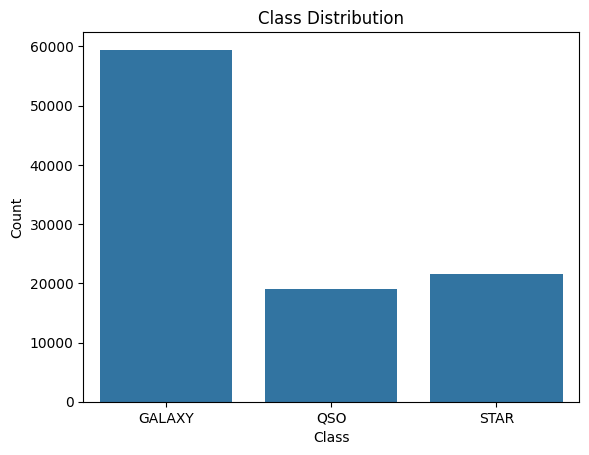

In [9]:
# let's see the class distribution, is it balanced or imbalanced?
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
# The class distribution is imbalanced, I will handle it later

<h1><center> Preprocessing</center><h1>

In [10]:
# In ds there are some columns that are not useful for my analysis, so I will drop them
df.drop(["obj_ID", "run_ID", "rerun_ID", "field_ID", "spec_obj_ID", "fiber_ID", "MJD", "plate"], axis=1, inplace=True)

In [11]:
# Let's take a look at the class distribution again
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [12]:
# Convert the 'class' column to numerical values with LabelEncoder
Label_encoder_ = LabelEncoder()
df['class'] = Label_encoder_.fit_transform(df['class'])
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [13]:
# Saving the class names:
class_names = Label_encoder_.classes_.tolist()
class_names



['GALAXY', 'QSO', 'STAR']

In [14]:
# Save the class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

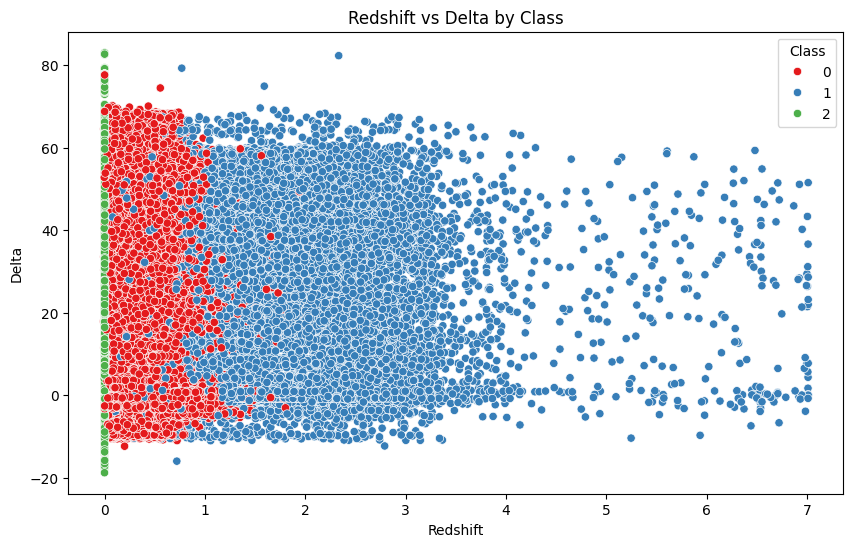

In [15]:
# let's check the relationship between coordinates and redshift
plt.figure(figsize=(10, 6))
sns.scatterplot(x='redshift', y='delta', hue='class', data=df, palette='Set1')
plt.title('Redshift vs Delta by Class')
plt.xlabel('Redshift')
plt.ylabel('Delta')
plt.legend(title='Class', loc='upper right')
plt.show()
# From the plot, I can learn that Stars are mostly at low redshift, which means they are closer to us.
# Galaxies are at medium redshift, and Quasars are at high redshift.

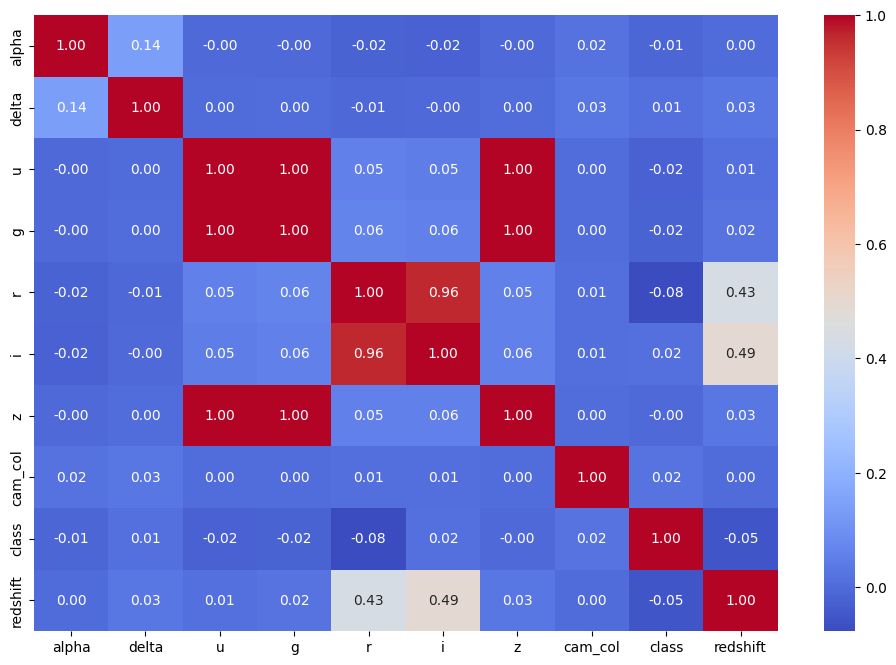

In [16]:
# correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()
# I can see high correlation among photometric columns.

In [17]:
# using the variance inflation factor (VIF) to check for multicollinearity in the dataset
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
vif_data
# VIF shows the same high correlation among photometric columns.

,feature,VIF
0,alpha,4.392366
1,delta,2.546511
2,u,1143.911063
3,g,4013.866021
4,r,3713.382530
5,i,3535.381860
6,z,2263.392831
7,cam_col,5.772175
8,class,2.058585
9,redshift,2.038280


In [18]:
# let's check the all photometric  columns which have high correlation with each other after handling the outliers
df[['u', 'g', 'r', 'i', 'z']].describe()

,u,g,r,i,z
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,21.980468,20.531387,19.645762,19.084854,18.668810
std,31.769291,31.750292,1.854760,1.757895,31.728152
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000
25%,20.352353,18.965230,18.135828,17.732285,17.460677
50%,22.179135,21.099835,20.125290,19.405145,19.004595
75%,23.687440,22.123767,21.044785,20.396495,19.921120
max,32.781390,31.602240,29.571860,32.141470,29.383740


 These column have high correlation with each other and the multicollinearity can effect on th model so I have to create a column for them by their sum/mean, Weighted average and PCA.  I searched on the internet that weighted average is better specially if one of them has significant impact on the class's values. so I try to use chi squared scores to find importance of photometric filters columns


In [19]:
# Create X and y
X = df.drop("class", axis = 1)
y= df["class"]

In [20]:
# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_features.fit(X_cat, y.astype(int))

# use decimal format in table
pd.options.display.float_format = '{:.2f}'.format

# the higher the score, the more effect that column has on the target
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns, df_features], axis=1)
f_scores.columns = ['Features', 'Score']
f_scores.sort_values(by='Score', ascending=False)
# I got code structure from  lecture notes.

,Features,Score
8,redshift,94218.97
1,delta,6229.70
6,z,2898.85
5,i,2366.07
0,alpha,2304.28
2,u,1813.91
4,r,1505.24
3,g,1400.40
7,cam_col,38.65


redshift and delta have more effected on the  class values

In [21]:
# Creating new column photometric_filters to store the weighted average of the photometric data columns
df_filers = df[['u', 'g', 'r', 'i', 'z']]


X_cat = df_filers.astype(int)
X_cat = X_cat.clip(lower=0)

chi_features = SelectKBest(chi2, k=len(X_cat.columns))
best_features = chi_features.fit(X_cat,y.astype(int))


# the higher the score, the more effect that column has on the target
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(df_filers.columns)
f_score = pd.concat([df_columns,df_features],axis=1)
f_score.columns = ['Features','Score']
f_score.sort_values(by='Score',ascending=False)

,Features,Score
4,z,2898.85
3,i,2366.07
0,u,1813.91
2,r,1505.24
1,g,1400.40


In [22]:
# After finding the score of each column, I will find the total score of each column
total_score =  f_score['Score'].sum()
total_score

9984.474754726089

In [23]:
# Calculate normalized weights and store them in the list
weights = [score / total_score for score in f_score['Score']]

# I need to sort the weights values and create a new  dataframe to store the weights and each column
df_weights = pd.DataFrame(weights, columns=['Weights'])
df_weights['Features'] = f_score['Features']
df_weights

,Weights,Features
0,0.18,u
1,0.14,g
2,0.15,r
3,0.24,i
4,0.29,z


In [24]:
# After Finding the weight of each column, I will a create a new column 'photometric_filters' to store the weighted average of the photometric data columns
df['photometric_filters'] = (df['u'] * df_weights['Weights'][0]) + (df['g'] * df_weights['Weights'][1]) + (df['r'] * df_weights['Weights'][2]) + (df['i'] * df_weights['Weights'][3]) + (df['z'] * df_weights['Weights'][4])
df.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,photometric_filters
0,135.69,32.49,23.88,22.28,20.40,19.17,18.79,2,0,0.63,20.54
1,144.83,31.27,24.78,22.83,22.58,21.17,21.61,5,0,0.78,22.40
2,142.19,35.58,25.26,22.66,20.61,19.35,18.95,2,0,0.64,20.96
3,338.74,-0.40,22.14,23.78,21.61,20.50,19.25,3,0,0.93,21.06
4,345.28,21.18,19.44,17.58,16.50,15.98,15.54,3,0,0.12,16.78


In [25]:
# Now I dont need u, g, r, i and  z anymore, so I will drop them from the DS
df = df.drop(['u', 'g', 'r', 'i', 'z', 'cam_col'], axis=1)

In [26]:
df.shape

(100000, 5)

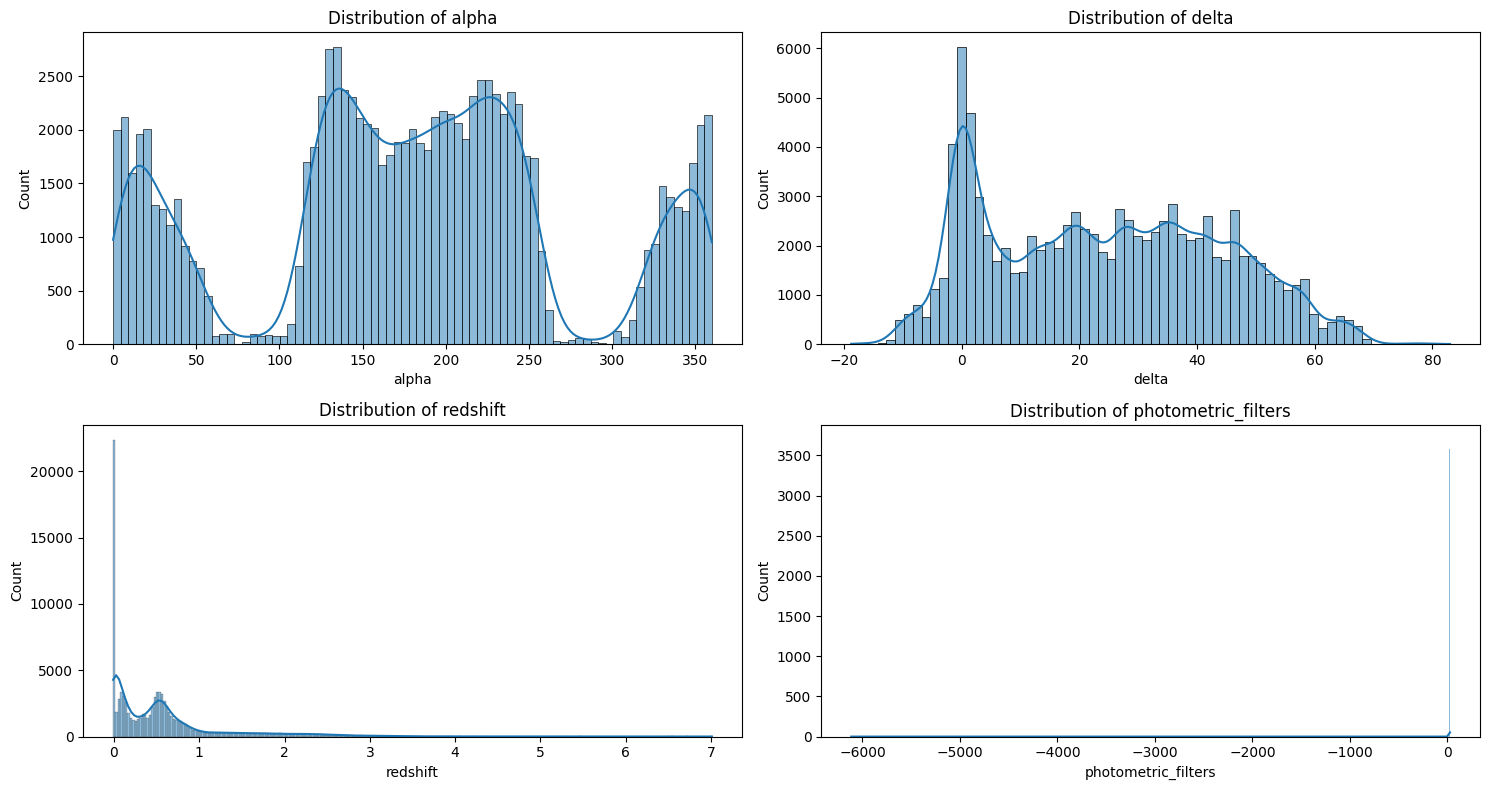

In [27]:
# let's see the distribution of the features columns
features_columns= df[['alpha', 'delta', 'redshift', 'photometric_filters']]
# I have 6 numeric columns, I need to create 2D grid of axes 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
for column, ax in zip(features_columns, axes.ravel()):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()
# Alpha and Delta have normal distribution, but redshift is right-skewed.

In [28]:
model = IsolationForest(n_estimators= 300, contamination= 0.1, random_state=42) 
model.fit(df)

df['outlier'] = model.predict(df)

# Creating mask for normal data 
# +1 is normal data 
# -1 is outlier
mask = df['outlier'] == 1
# Removing outliers by filtering with the mask
clean_df = df[mask]
clean_df = clean_df.drop('outlier', axis=1)

print("Original rows:", len(df))
print("Clean rows:", len(clean_df))
df = clean_df

Original rows: 100000
Clean rows: 90000


In [29]:
# Some columns have many decimal places, I will round them to 2 
df = df.round({'alpha': 2, 'delta': 2, 'redshift': 2, 'photometric_filters': 2})

In [30]:
# save the dataset to a new csv file as training data 
df.to_csv('classification_cleaned.csv', index=False)